# Objetivo

O objetivo do trabalho em questão é criar um pipeline de dados que permita disponibilizar um conjunto de dados referente a população mundial para análise. Objetiva-se com isso responder algumas questões relevantes, a saber:

1 - Primeiros cinco países com maior população

2 - Soma da população dos cinco países com maior tamanho populacional

3 - 3 Países com maior crescimento populacional absoluto em 2018

4 - 3 Países com maior crescimento populacional percentual

5 - Variação populacional percentual média

A partir desse conjunto de perguntas, será possível entender aspectos demográficos referentes a distintos países. Tais aspectos fornecem subsídios para a compreensão de diversos fatores relacionados ao crescimento populacional, como fluxo internacionais de capitais, estimativas relacionadas ao consumo, aquecimento global, fluxo migratório, entre outros.


# 1. Busca pelos dados

Os dados escolhidos compõe o dataset Country Population and Growth Rate Analysis, disponibilizado pelo Kaggle no link a seguir: https://www.kaggle.com/datasets/gauravkumar2525/country-population-and-growth-rate-analysis?resource=download

# 2. Coleta e Armazenamento
Foi feito o download, pelo Kaggle, do conjunto de dados em formato csv. Criou-se um bucket no Google Cloud Plataform, hospedado em us-east1 (Carolina do Sul), com a classe de armazenamento Standard, acesso não público e nomeado countries_population. Foi feito o upload do csv no bucket, conforme demonstrado abaixo:

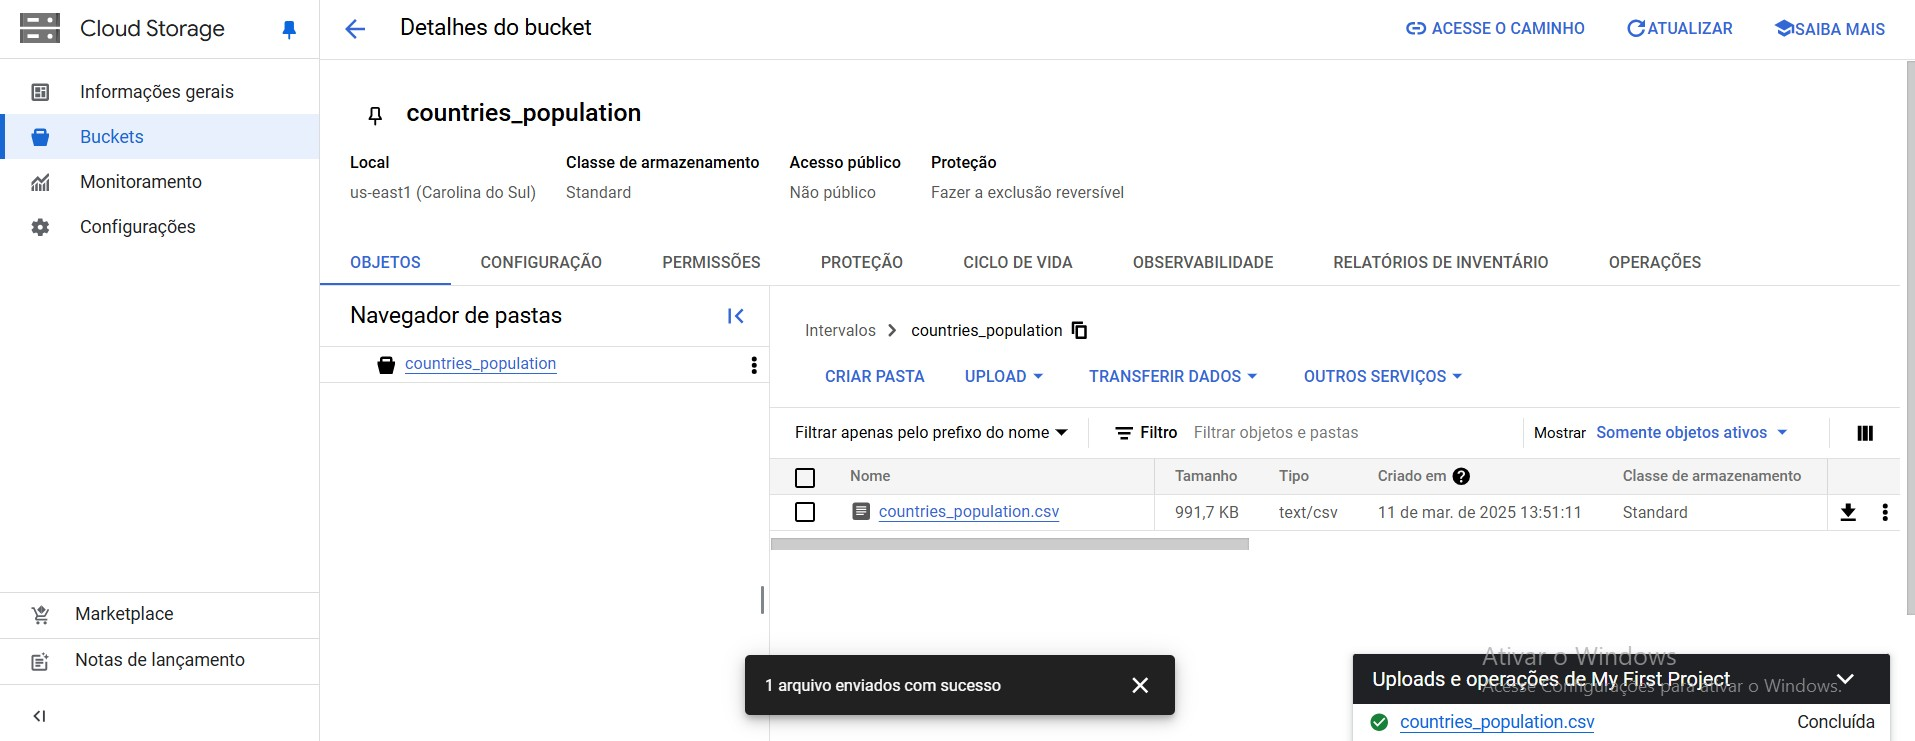






Posteriormente, procedeu-se à criação do conjunto de dados dentro do BigQuery a partir do bucket anteriormente criado:

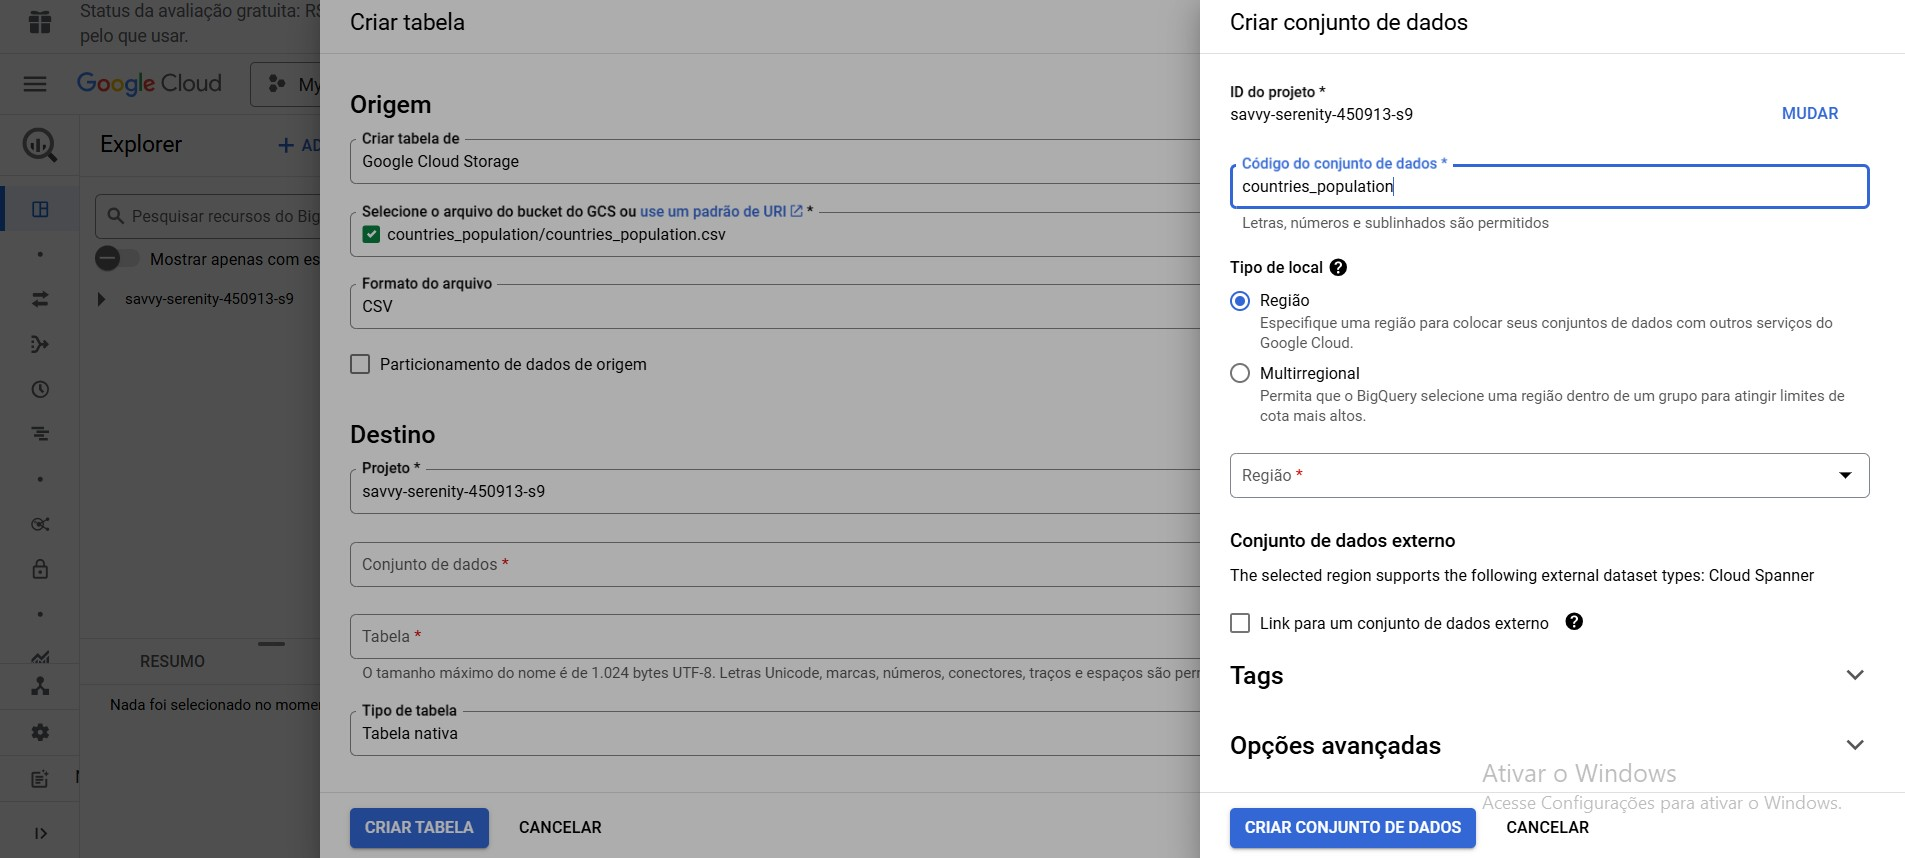


Após isso, foi criada a tabela countries_population:

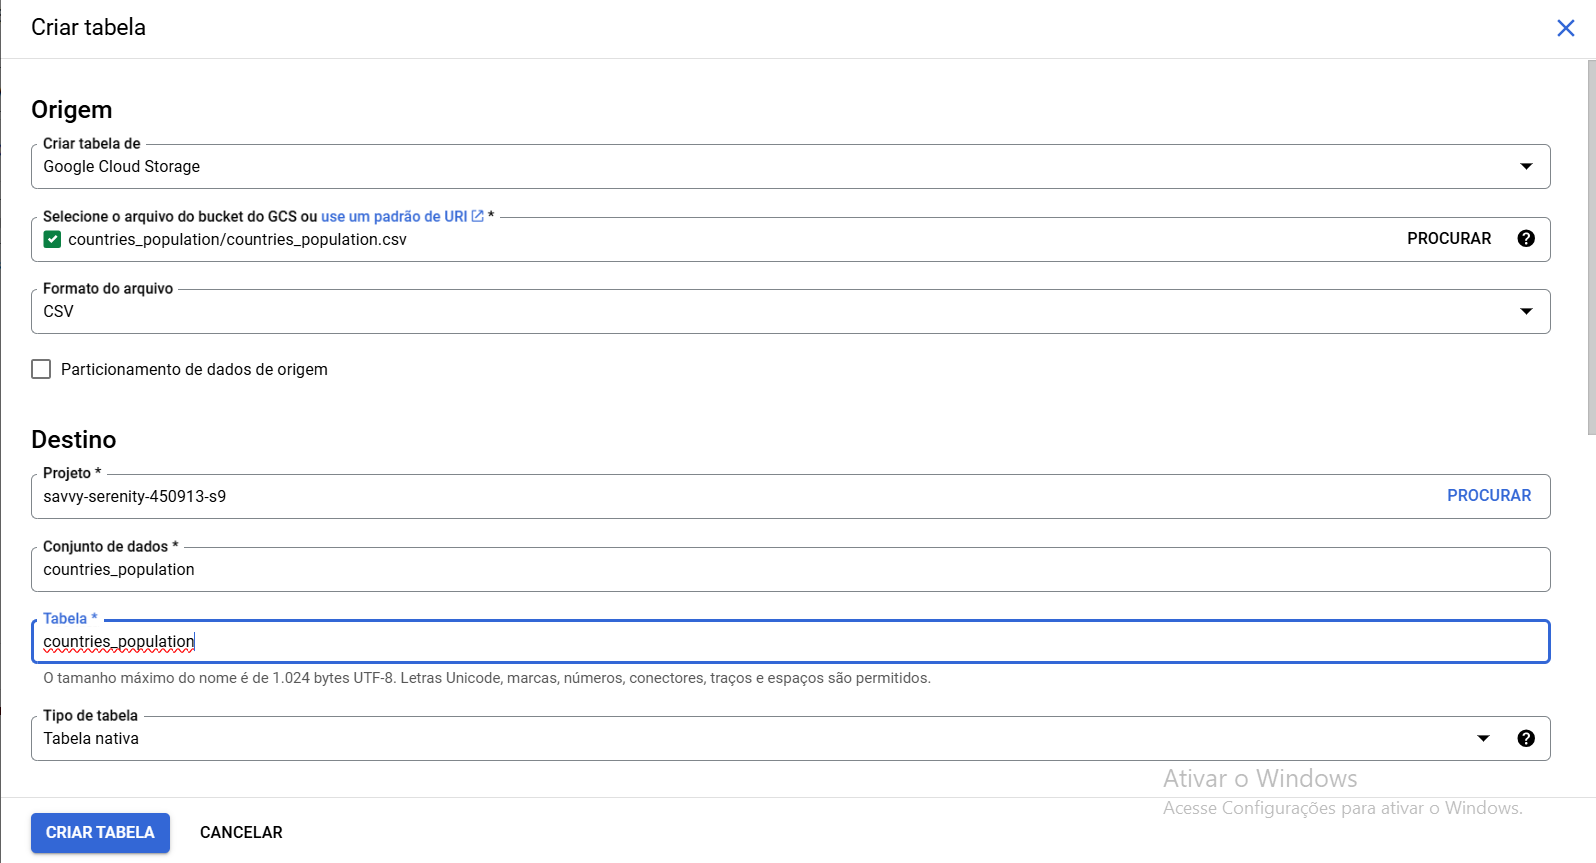

O esquema dos dados foi criado conforme a seguir:

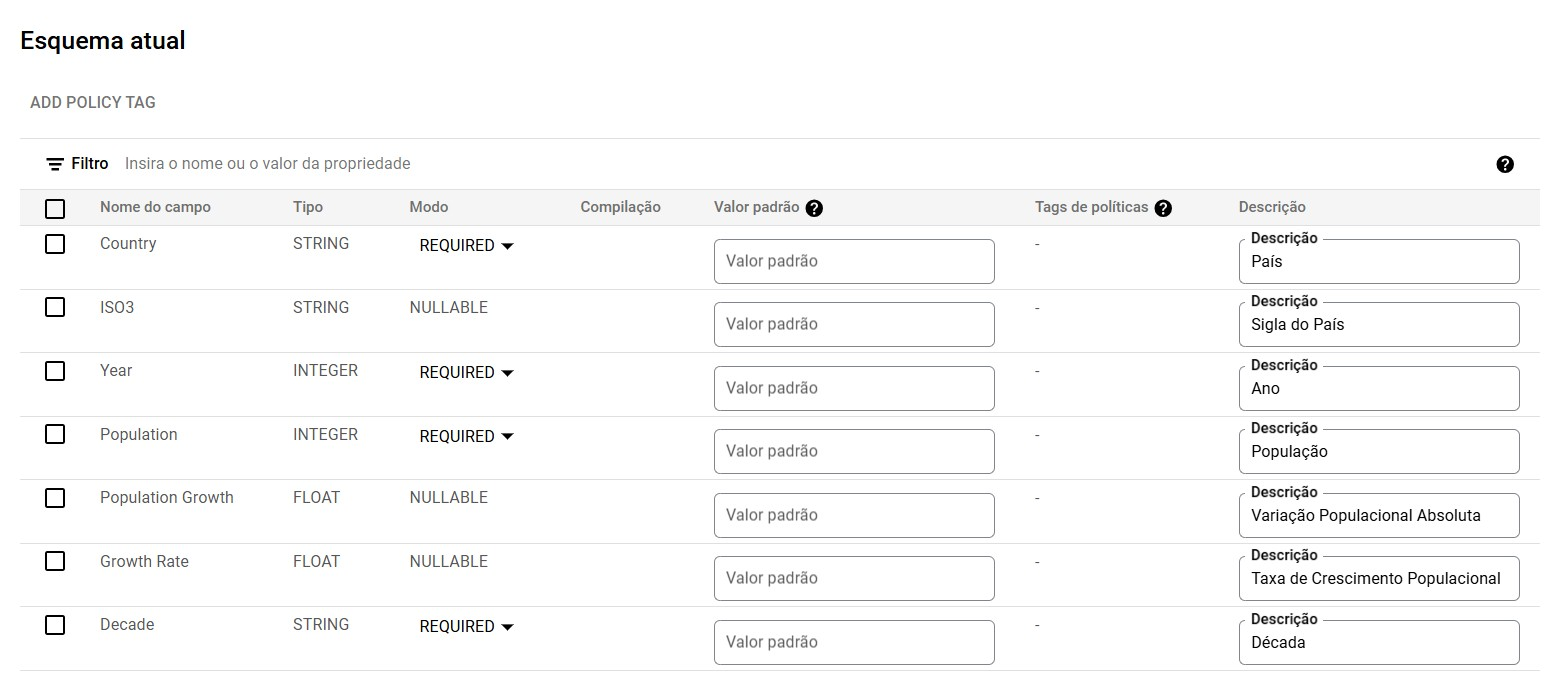

# 3. Modelagem

## Catálogo de Dados
O conjunto de dados é composto pelas colunas a seguir:

Country: o nome do país ou região ao qual determinado registro se refere. Existem 263 possíveis nomes para essa coluna. O campo é uma string não nula.

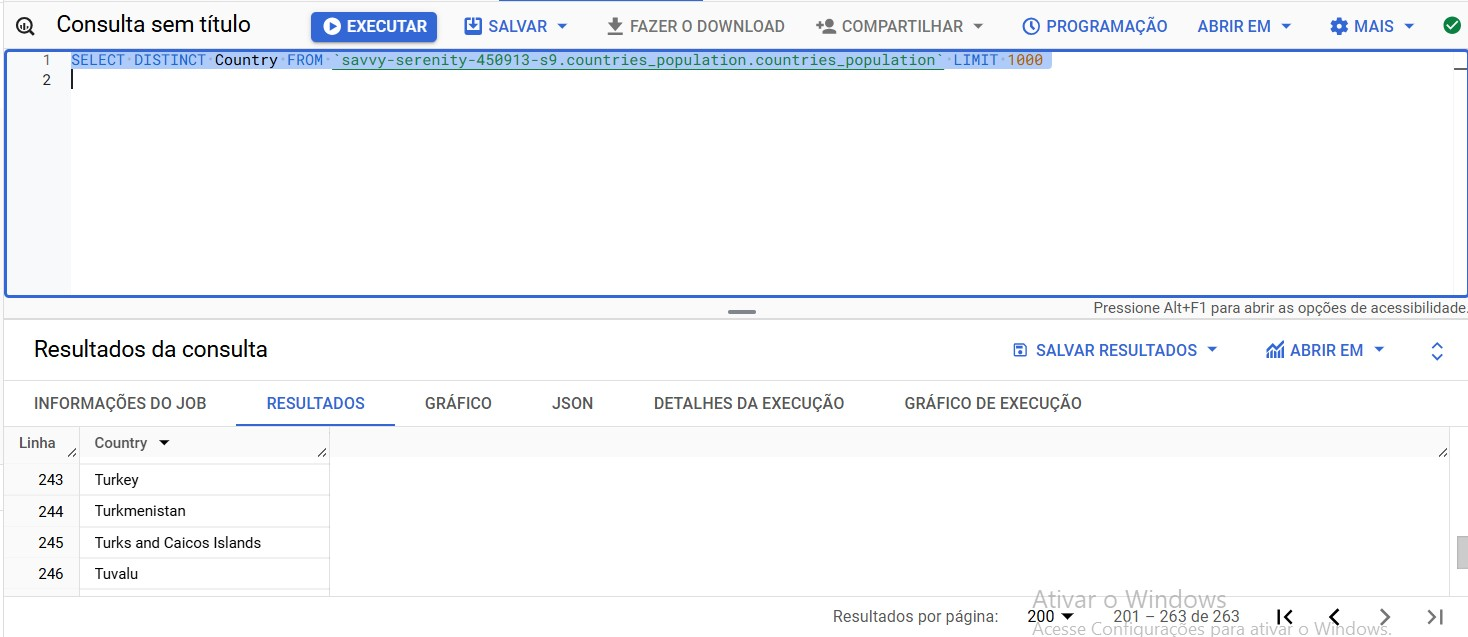

ISO3: é a sigla do país ou região. Exemplo: Brazil é BRA. Tambem possui 263 valores distintos. O campo é uma string que pode ser nula.

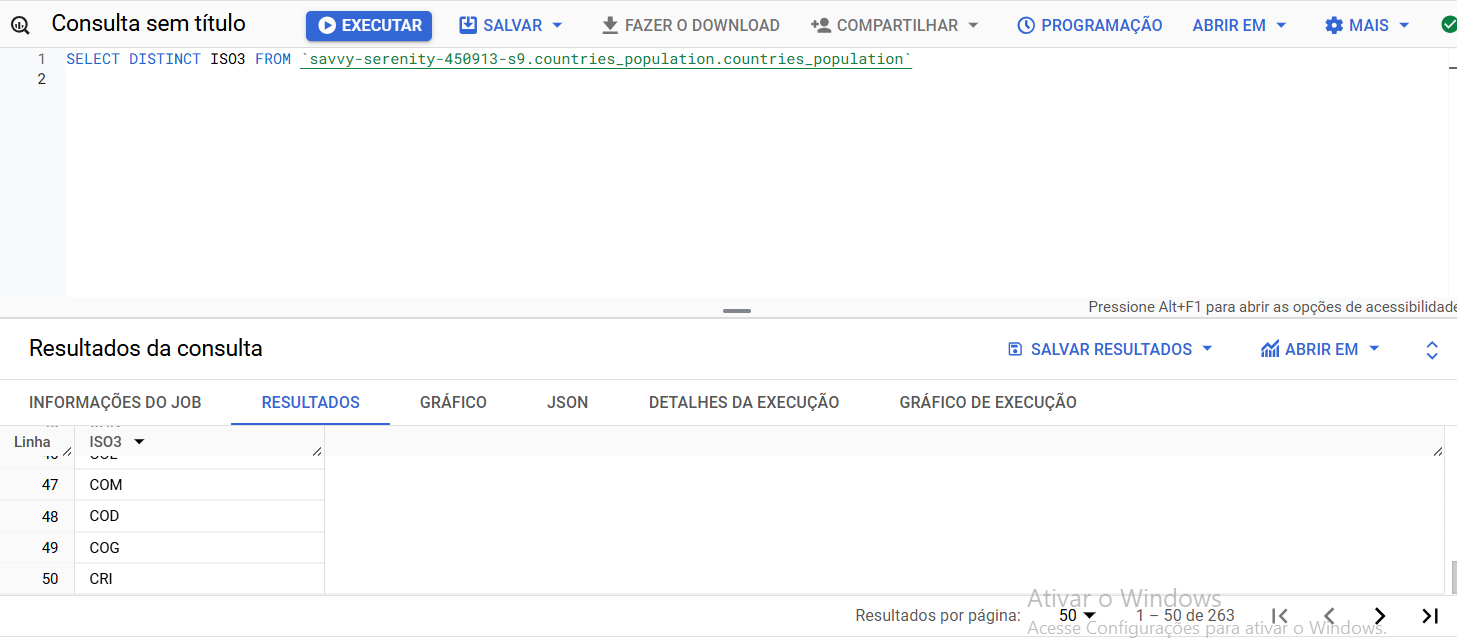

Year: ano ao qual determinado registro se refere. Campo inteiro e não nulo. Os dados vão de 1960 à 2018:

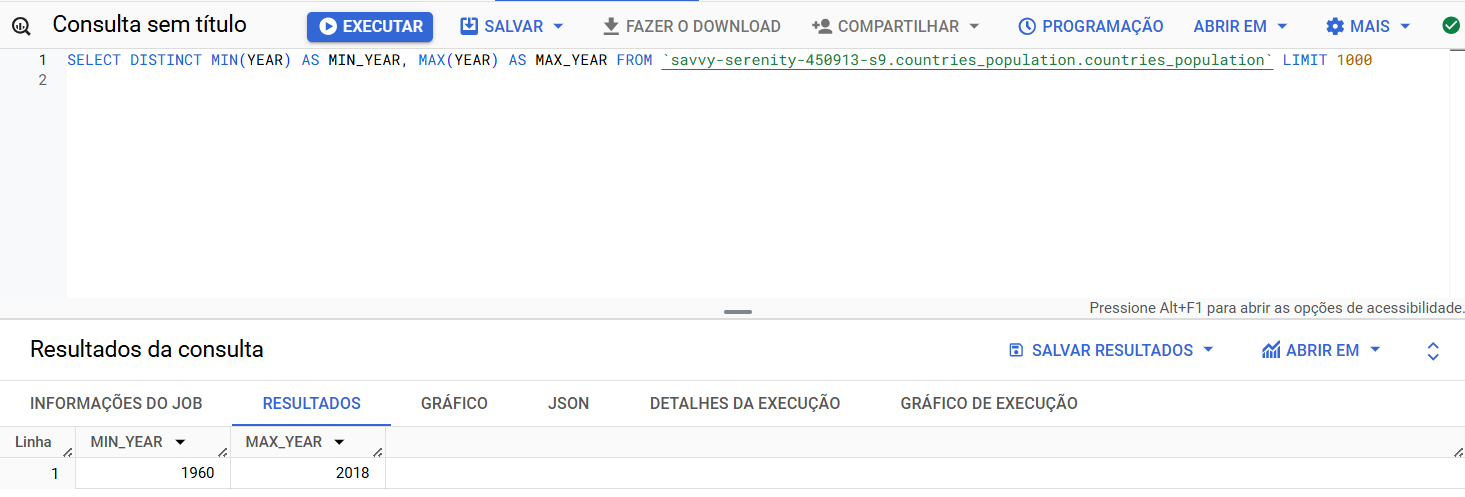

Population: a população total de determinado país ou região em determinado ano. Campo inteiro e não nulo.

Population Growth: O crescimento populacional absoluto de determinado país comparado ao ano anterior. Campo do tipo float e passível de preenchimento nulo.

Growth Rate: a variação percentual populacional comparada ao ano anterior. Campo do tipo float e passível de preenchimento nulo.

Decade: a década a qual determinados registros se referem para agrupamentos de longo termo. Campo do tipo string e não nulo.


# Modelagem dos dados.

Devido a natureza do conjunto de dados, os dados foram modelados em apenas uma tabela contemplando todas as colunas necessárias às análises.


# Linhagem dos dados:

Os dados foram extraídos em formato csv a partir dos datasets do Kaggle, ingeridos em um bucket do Google Cloud Platform e, por fim, transformados em uma tabela do Big Query. Dentro do Big Query, não existem tabelas intermediárias, conforme mostrado a seguir:

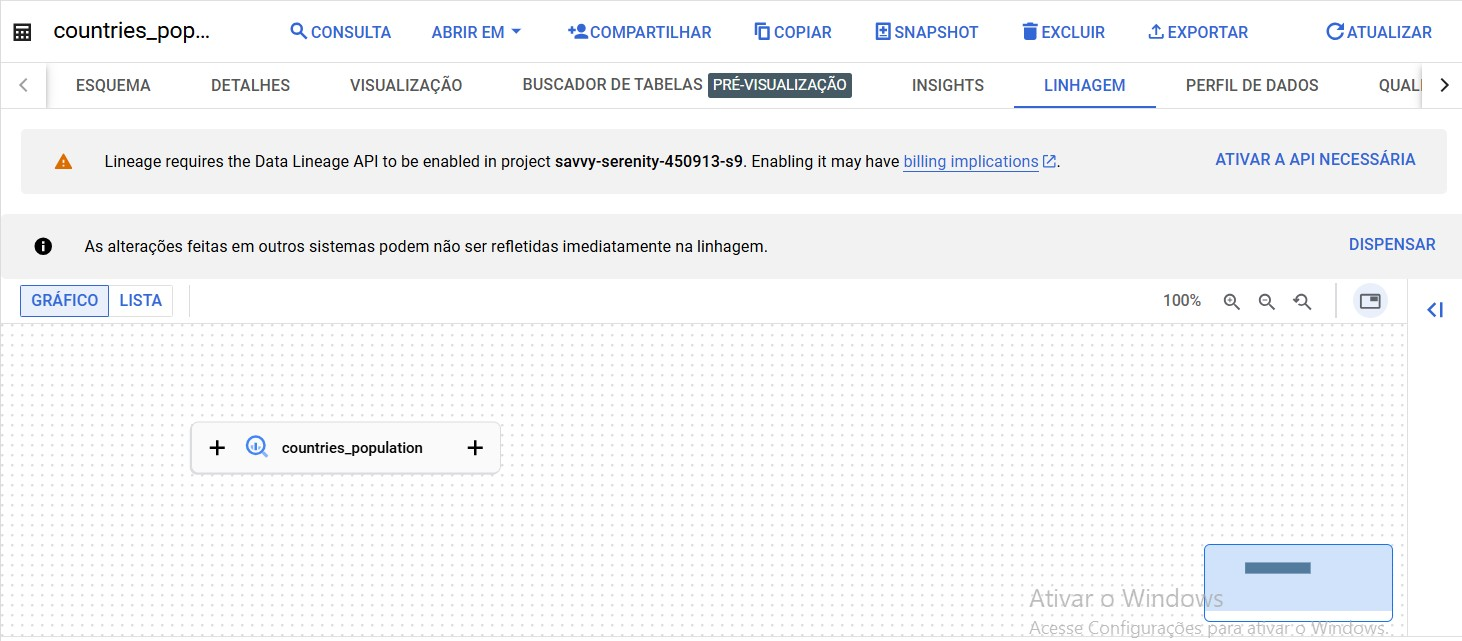

# 4. Carga

Para o processo de extração, transformação e carga, elaborou-se uma query que retirou registros que são agregações presentes nos dados, como a população mundial, União Europeia, Asia Central, entre outros.

Query utilizada:

CREATE OR REPLACE TABLE `savvy-serenity-450913-s9.countries_population.countries_population` AS
SELECT
    *
FROM `savvy-serenity-450913-s9.countries_population.countries_population`
WHERE Country not in
(
  'Arab World',
'Central African Republic',
'Central Europe and the Baltics',
'Early-demographic dividend',
'East Asia & Pacific',
'East Asia & Pacific (IDA & IBRD countries)',
'Euro area',
'Europe & Central Asia',
'Europe & Central Asia (IDA & IBRD countries)',
'Europe & Central Asia (excluding high income)',
'European Union',
'Fragile and conflict affected situations',
'Heavily indebted poor countries (HIPC)',
'High income',
'IBRD only',
'IDA & IBRD total',
'IDA blend',
'IDA only',
'IDA total',
'Late-demographic dividend',
'Latin America & Caribbean',
'Latin America & Caribbean (excluding high income)',
'Latin America & the Caribbean (IDA & IBRD countries)',
'Least developed countries: UN classification',
'Low & middle income',
'Low income',
'Lower middle income',
'Middle East & North Africa',
'Middle East & North Africa (IDA & IBRD countries)',
'Middle East & North Africa (excluding high income)',
'OECD members',
'Other small states',
'Pacific island small states',
'Post-demographic dividend',
'Pre-demographic dividend',
'Small states',
'South Asia',
'South Asia (IDA & IBRD)',
'Sub-Saharan Africa',
'Sub-Saharan Africa (IDA & IBRD countries)',
'Sub-Saharan Africa (excluding high income)',
'World'
)


Após isto, a consulta em questão foi programada para ser executada diariamente, às 05:00 (UTC), visando automatizar o processo de tratamento dos dados,  conforme demonstrado abaixo:

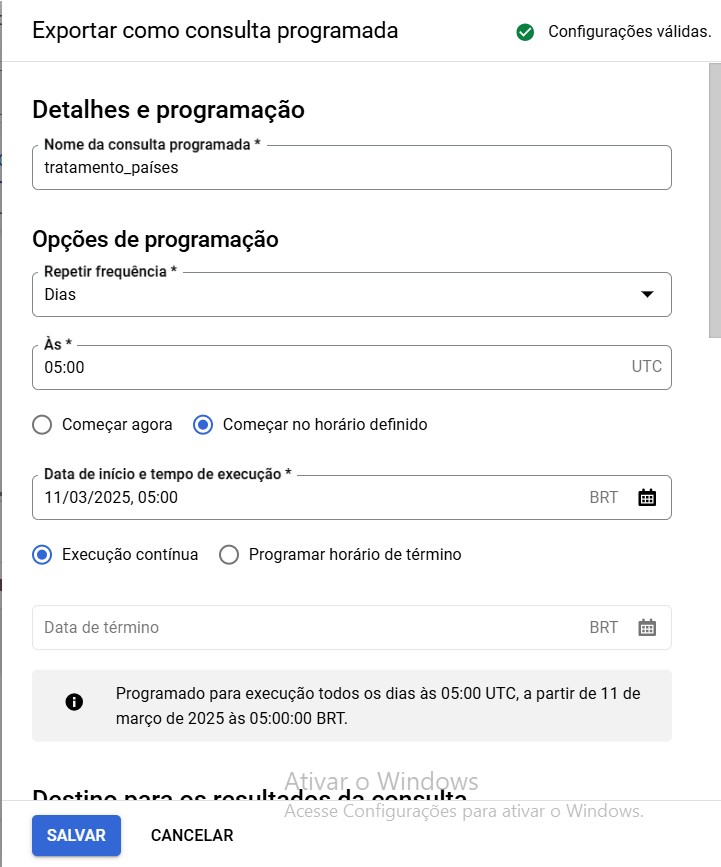



Após o tratamento, é possível perceber que a quantidade de países foi reduzida de 263 para 221:

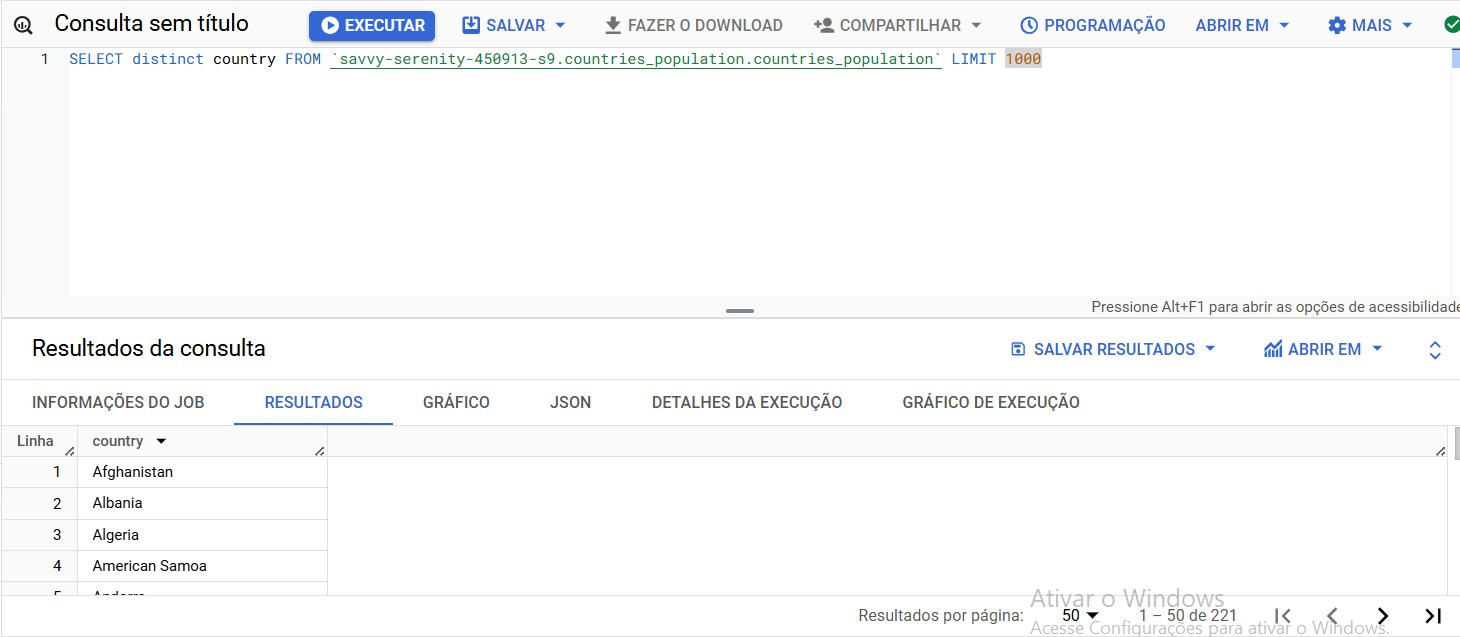


# 5. Análise

Qualidade dos dados: o principal problema relacionado a qualidade dos dados é a existência de registros agregados. Ao invés de termos registros apenas por países, o conjunto de dados tem agregações a nível mundial, regional e outras. O tratamento de dados efetuado solucionou tal problema. Existem, também, dados nulos referentes a variação populacional, seja percentual ou absoluta, por ser o primeiro registro relacionado a determinado país, de modo que não seja possível comparar com um registro anterior para o cálculo da variação. Tal ponto, no entanto, não constitui um erro e sim uma característica do conjunto de dados. Também é possível perceber que nem todos os países possuem registros anuais referentes ao tamanho da sua população, conforme demonstrado através da consulta a seguir:

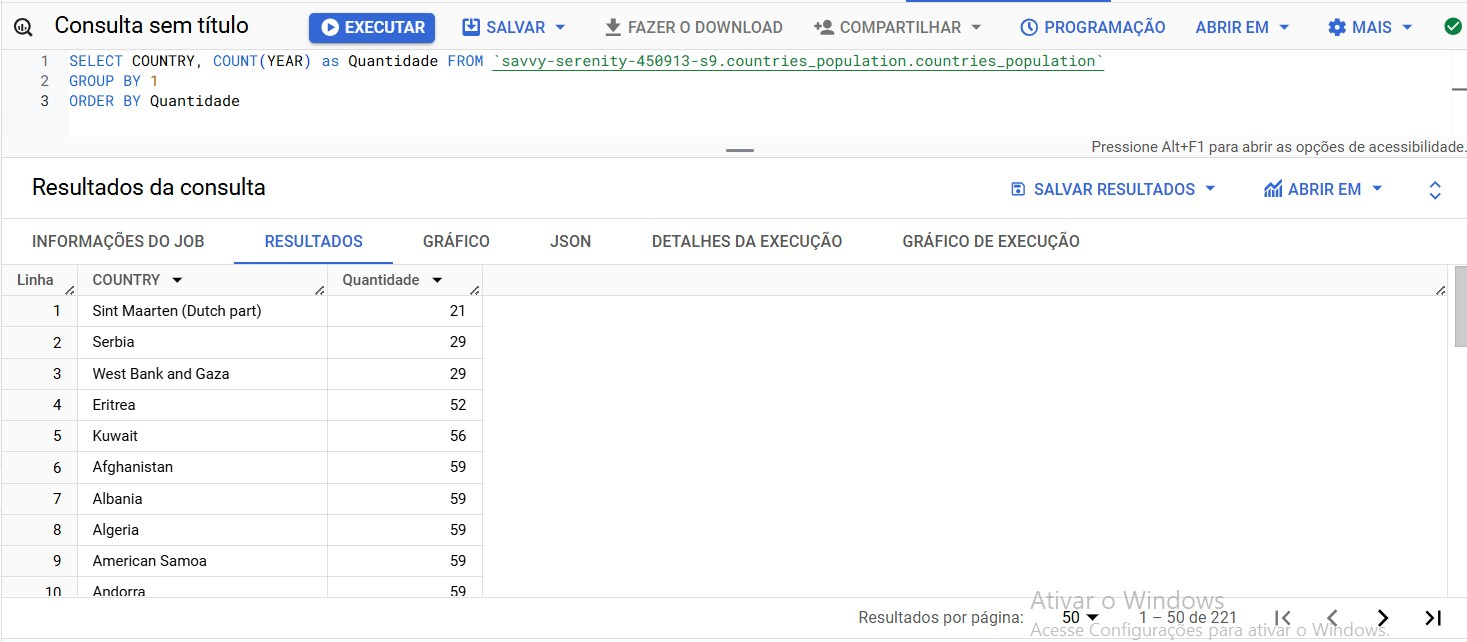



**1 - 5 Países com maior população**

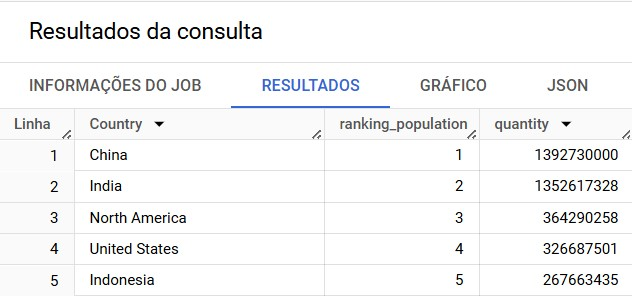

Com base nos resultados apresentados, é possível perceber que o primeiro e segundo lugar, China e Índia, apresentam uma população significativamente maior que os demais. Considerando que são países que têm apresentado um considerável crescimento econômico nos últimos anos, o tamanho populacional de tais países permite compreender a crescente relevância mundial de ambos os países, além do grande impacto ambiental que podem causar. A query utilizada pra chegar no resultado em questão é demonstrada a seguir:

WITH ranking_year_tbl as (

SELECT COUNTRY, ROW_NUMBER() OVER (PARTITION BY COUNTRY ORDER BY Year DESC) as ranking_year, population as Quantidade

FROM `savvy-serenity-450913-s9.countries_population.countries_population`),

ranking_population_tbl as (SELECT

*,
RANK() OVER (ORDER BY Quantidade DESC) as ranking_population
FROM ranking_year_tbl
WHERE ranking_year = 1
)


SELECT
Country, ranking_population, quantidade as quantity
FROM ranking_population_tbl
WHERE ranking_population <= 5
ORDER BY ranking_population ASC



**2 - Soma da população dos cinco países mais populosos**

A soma da população é de 3703988522. Considerando que a população mundial, em 2018, foi de ~7,7 bilhões de pessoas, compreende-se a relevância destes cinco países em termos populacionais, já que são responsáveis por quase a metade da população global sem, no entanto, corresponderem a 3% da quantidade de países.

Query:

WITH ranking_year_tbl as (
SELECT COUNTRY, ROW_NUMBER() OVER (PARTITION BY COUNTRY ORDER BY Year DESC) as ranking_year, population as Quantidade

FROM savvy-serenity-450913-s9.country_pop.country_pop),

ranking_population_tbl as (SELECT

*,
RANK() OVER (ORDER BY Quantidade DESC) as ranking_population
FROM ranking_year_tbl
WHERE ranking_year = 1
)


SELECT
SUM(quantidade) as sum_population
FROM ranking_population_tbl
WHERE ranking_population <= 5


**3 - 3 Países com maior crescimento populacional absoluto em 2018**

Índia, com 13958493;
China, com 6335000;
Nigéria, com 5001429.

Importante destacar que a Nigéria, país em terceiro lugar no ranking, está apresentando um crescimento absoluto elevado, mesmo sem pertencer ao ranking dos 5 países com o maior tamanho populacional. Tal informação nos da indícios de que podem haver alterações no ranking de países pelo crescimento populacional e que poderão surgir novos centros de capitais e consumo.

Query:

WITH ranking_population_growth_tbl as (
SELECT COUNTRY, ROW_NUMBER() OVER (ORDER BY Population_Growth DESC) as ranking_population_growth, population_growth
FROM savvy-serenity-450913-s9.country_pop.country_pop
WHERE Year = '2018')


SELECT
*
FROM ranking_population_growth_tbl
WHERE ranking_population_growth <= 3

**4 - 3 Países com maior crescimento populacional percentual em 2018**

Os três países são:
Bahrain, com 5,04%;
Nigéria, com 3,89%;
Maldives, com 3,88%.

Os países em questão, especialmente o Bahrain e Maldives, contribuem com a afirmação de que o crescimento demográfico varia entre os países ao longo dos anos. Isso significa que o ranking populacional provavelmente mudará e isso poderá alterar fluxos de capitais e consumo, emissão de poluentes, entre outros temas relevantes do século XXI.

WITH ranking_population_growth_tbl as (
SELECT COUNTRY, ROW_NUMBER() OVER (ORDER BY Growth_Rate DESC) as ranking_population_growth, Growth_Rate
FROM savvy-serenity-450913-s9.country_pop.country_pop
WHERE Year = '2018')


SELECT
*
FROM ranking_population_growth_tbl
WHERE ranking_population_growth <= 3

**5 - Variação populacional percentual média**

A variação populacional percentual média foi de 1,78% no período analisado e de 1,21% em 2018. Percebe-se que o crescimento percentual médio está diminuindo, conforme as principais estimativas sugerem. Isso indica que o crescimento econômico deverá vir cada vez mais do desenvolvimento tecnológico e melhores alocações de recuros ao invés do mero crescimento populacional, destacando a importância dos investimentos para um crescimento sustentável.

Queries:

SELECT avg(Growth_Rate) FROM `savvy-serenity-450913-s9.country_pop.country_pop`

SELECT avg(Growth_Rate) FROM `savvy-serenity-450913-s9.country_pop.country_pop`
WHERE Year = 2018

Baseado nas respostas alcançadas, percebe-se uma tendência de crescimento populacional, no entanto uma tendência de crescimento menor do que a ocorrida em décadas anteriores, com uma dinâmica distinta. Outro aspecto importante é a mudança em relação aos países com as maiores taxas de crescimento. Tal fato permite compreender que poderão haver alterações no ranking de países com maior tamanho populacional. Todas essas características ressaltam para possíveis mudanças nos fluxos migratórios, de capitais e de consumo, com impactos diretos no meio ambiente. A possibilidade de identificar essas tendências permite a adoção de medidas preventivas visando lidar com questões relacionadas a infraestrutura necessária ao crescimento populacional, fornecimento de serviços, bens de consumo, impactos ambientes e muitos outros. Com isso, conclui-se que as perguntas elencadas foram satisfatóriamente cobertas e respondidas através do pipeline de dados ora desenvolvido.